20181112

## 銜接前一日

In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets
from PIL import Image

In [7]:
def load_data():
    mnist = datasets.fetch_mldata('MNIST original')
    n_train = 6000
    data_train = mnist.data[:n_train]
    target_train = mnist.target[:n_train]
    data_test = mnist.data[n_train:]
    target_test = mnist.target[n_train:]
    return (data_train.astype(np.float32), target_train.astype(np.float32),data_test.astype(np.float32), target_test.astype(np.float32))

def img_show(img):
    pil_img = Image.fromarray(np.uint8(img))
    pil_img.show()

In [8]:
x_train, t_train, x_test, t_test  = load_data()

In [9]:
x_test_2 = x_test/256

In [10]:
import pickle
def init_network():
    with open('sample_weight.pkl','rb') as f:
        network = pickle.load(f)
    return network

In [13]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [12]:
def softmax(x):
    c = np.max(x)
    exp_a = np.exp(x-c) #防止溢位
    sum_exp_a = np.sum(exp_a)
    return exp_a / sum_exp_a

In [11]:
def predict(network,x):
    W1,W2,W3 = network['W1'],network['W2'],network['W3']
    b1,b2,b3 = network['b1'],network['b2'],network['b3'] 
    
    a1 = np.dot(x,W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1,W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2,W3) + b3
    y = softmax(a3) # 輸出層
    return y

In [14]:
network = init_network()

In [29]:
%time
accuracy_cnt = 0
for i in range(len(x_test_2)):
    y = predict(network,x_test_2[i])
    p = np.argmax(y)
    if p == t_test[i]:
        accuracy_cnt += 1
print("Accuracy:%f"%(float(accuracy_cnt)/len(x_test_2)))

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 9.06 µs
Accuracy:0.932219


In [21]:
index = 41654
t_test[index]

7.0

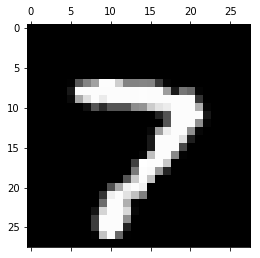

In [26]:
plt.matshow(np.uint8(x_test[index]).reshape(28,28), cmap=plt.cm.gray)
plt.show()

In [28]:
# 預測輸出結果
y = predict(network,x_test_2[index])
np.argmax(y)

7

## 批次處理

In [32]:
%time
batch_size = 100
accuracy_cnt = 0
for i in range(0,len(x_test),batch_size):
    x_batch = x_test_2[i:i+batch_size]
    y_batch = predict(network,x_batch)
    p = np.argmax(y_batch,axis =1)
    accuracy_cnt += np.sum(p == t_test[i:i+batch_size])
print("Accuracy:%f"%(float(accuracy_cnt)/len(x_test_2)))

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs
Accuracy:0.932219


## 了解一下np.argmax

In [36]:
x = np.array([[0.1,0.8,0.1],[0.3,0.1,0.6],[0.2,0.5,0.3],[0.8,0.1,0.1]],dtype=np.float32)
x

array([[ 0.1       ,  0.80000001,  0.1       ],
       [ 0.30000001,  0.1       ,  0.60000002],
       [ 0.2       ,  0.5       ,  0.30000001],
       [ 0.80000001,  0.1       ,  0.1       ]], dtype=float32)

In [38]:
y = np.argmax(x,axis=1)
y

array([1, 2, 1, 0])

# Chapter4 神經網路的學習

### loss function

#### mean squared error 均方誤差
$$ E = \frac{1}{2}\sum (y_k-t_k)^2 $$

In [39]:
def mean_squared_error(y,t):
    return 0.5 * np.sum((y-t)**2)

### 交叉entropy誤差
$$ E = -\sum_k t_k \log y_k $$

In [49]:
def cross_entropy_error(y,t):
    delta = 1e-7
    return -np.sum(t*np.log(y+delta))

In [56]:
t = np.zeros(10)
t[2] = 1
y = np.array([0.1,0.05,0.6,0.0,0.05,0.1,0.0,0.1,0.0,0.0])
cross_entropy_error(y,t)

0.51082545709933802

### 小批次學習
假設有N個需要學習的資料，其平均誤差可以是個別誤差的平均
$$ E = -\frac{1}{N}\sum_n\sum_k t_{nk}\log y_{nk} $$
由於不太能一次將所有的資料都拿來學習，所以可以在整體的資料中，隨機選取出幾張，然後用那幾張來學習．那就是所謂的小批次學習

In [82]:
x_test.shape

(64000, 784)

In [83]:
t_test.shape[0]

64000

In [78]:
def one_hot_label(y,size):
    a = np.zeros([y.shape[0],size])
    for i in range(y.shape[0]):
        a[i,int(y[i])] = 1

    return a

In [86]:
b = one_hot_label(t_test,10)

In [87]:
b.shape

(64000, 10)

隨機選取部分的資料

In [91]:
train = x_test/256
test = t_test
train_size = train.shape[0]
batch_size = 10
# 最後選出的資料集
batch_mask = np.random.choice(train_size,batch_size)
x_batch = train[batch_mask]
t_batch = train[batch_mask]

改寫成批示對應版的cross_entropy_error

In [92]:
def cross_entorpy_error(y,t):
    if y.ndim == 1:
        t = t.reshape(1,t.size)
        y = y.reshape(1,y.size)
    batch_size = y.shape[0]
    return -np.sum(t*np.log(y))/batch_size

## 數值微分

In [93]:
def numerical_diff(f,x):
    h = 1e-4 # 容許在float32底下運作
    return (f(x+h)-f(x-h))/(2*h)

In [94]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

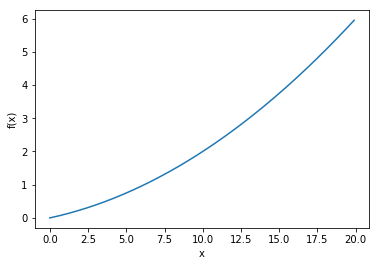

In [95]:
x = np.arange(0,20.0,0.1)
y = function_1(x)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.plot(x,y)
plt.show()

In [96]:
numerical_diff(function_1,5)

0.1999999999990898

In [97]:
def function_2(x):
    return np.sum(x**2)

[3d做圖參考](https://matplotlib.org/tutorials/toolkits/mplot3d.html#sphx-glr-tutorials-toolkits-mplot3d-py)

In [99]:
x = np.arange(0,20.0,0.1)
y = np.arange(0,20.0,0.1)
z = np.meshgrid(x,y)
plt.plot_surface(x,y,z)
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'plot_surface'

### 梯度

In [101]:
def numerical_gradient(f,x):
    h = 1e-4
    grad = np.zeros_like(x)
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = tmp_val+h
        fxh1= f(x)
        
        x[idx] = tmp_val-h
        fxh2= f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
    return grad
        

In [104]:
numerical_gradient(function_2,np.array([3.0,4.0]))

array([ 6.,  8.])

### 梯度法
$$ x_0 = x_0 - \eta\frac{\partial f}{\partial x_0} $$
$$ x_1 = x_1 - \eta\frac{\partial f}{\partial x_1} $$
$\eta$ = learning rate 

In [105]:
def gradient_descent(f,init_x,lr=0.01,step_num = 100):
    x = init_x
    for i in range(step_num):
        grad = numerical_gradient(f,x)
        x -= lr * grad
    return x

測試求 $ f(x_0,x_1) = x_0^2 + x_1^2 $ 的最小值

In [106]:
init_x = np.array([-3.0,4.0])
gradient_descent(function_2,init_x=init_x,lr=0.1,step_num=100)

array([ -6.11110793e-10,   8.14814391e-10])